# 7/12 (금) 실습


https://github.com/wcjang/hhi  
**Day 2 - 실습자료** 에서 다운로드

**필요한 데이터는 아래와 같습니다.**
0.   2024_chapter7~8.ipynb (주석이 포함된 파이썬 코드)
1.   web_page_data.csv
2.   four_sessions.csv
3.   click_rates.csv
4.   imanishi_data.csv
5.   fr_freq.xlsx
6.   kor_freq.xlsx

# Lecture 7 : 다양한 검정


## 1. T test

In [ ]:
# 패키지 설치
%matplotlib inline

import random

import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [ ]:
# 드라이브에 올려둔 data 파일을 사용합니다.
DATA = '/content/drive/MyDrive/Colab Notebooks/data'

WEB_PAGE_DATA_CSV = DATA + '/web_page_data.csv'
FOUR_SESSIONS_CSV = DATA + '/four_sessions.csv'
CLICK_RATE_CSV = DATA + '/click_rates.csv'
IMANISHI_CSV = DATA + '/imanishi_data.csv'

### 두 그룹 간의 비교 (Two group comparision)
- 페이지 A와 페이지 B 중 어느 페이지에서 사람들이 더 많이 머무는지를 알아보자.

In [ ]:
#데이터
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [ ]:
# 1초 단위로 바꾸자.
session_times.Time = 100 * session_times.Time
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


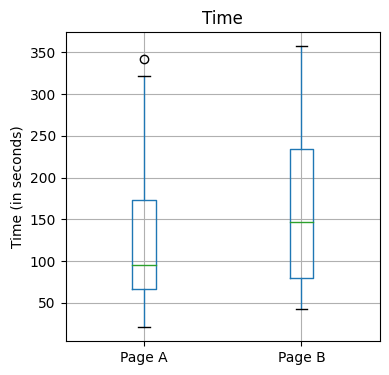

In [ ]:
#상자그림을 통해 비교해보자.

ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

* 전반적으로 B가 A보다 사람들이 머무는 시간이 김을 확인할 수 있다. 즉 B의 평균 > A의 평균이다.
* 평균 시간은 얼마나 차이날까?

In [ ]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


- 약 35.6초정도 평균시간의 차이가 존재한다. 즉 B평균 - A평균 = 35.6이다.
- 이제, t-test를 통해 이 차이가 유의하다고 말할 수 있을지 알아보자.

####T-test (T 검정)

- **귀무가설 : Page A와 Page B 세션 시간에는 차이가 없다. (A=B)**
- **대립가설 : Page A보다 Page B 세션 시간이 더 길다. (A<B)**  


- t test를 수행하기 위해서는 stats package의 **ttest_ind** 함수를 이용한다.

In [ ]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
# 1. 차례로 비교할 데이터들을 입력한다. 이 경우에는 Page A 의 시간과 Page B 의 시간을 차례로 입력하면 된다.

# 2. equal_var = 등분산 가정이 성립하는지를 의미한다.
# 일반적으로는 t-test를 수행하기에 앞서 등분산 검정을 수행해야 하지만,
# 이 경우 등분산 가정이 성립하지 않는다고 가정하자.

# 3. ttest_ind에서는 양측검정 (A != B) 에 대한 확률을 출력하는것이 default이다.
# 이 경우에는 단측검정 (A < B) 이므로, 구한 확률을 2로 나눠야 p-value 가 된다.

print('p-value : ', round(res.pvalue/2,4))



# 또는 alternative 옵션을 이용해도 된다. 단측검정을 위해서는 alternative='less' 로 지정한다.
# alternative = {'two-sided','less','greater'}; default is 'two-sided'

# alternative option을 이용해 p-value 계산
res_option = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                             session_times[session_times.Page == 'Page B'].Time,
                             equal_var=False,
                             alternative='less')

print('p-value using alternative option : ',round(res_option.pvalue,4))

p-value :  0.1408
p-value using alternative option :  0.1408


#### Permutation test (순열 검정)

- 위의 차이가 통계적으로 유의한지를 순열검정을 통해 알아보자.
- 모든 세션 시간을 섞어둔 후, 21개의 그룹 (A) 과 15개의 그룹(B) 으로 반복하여 표본을 추출하자.
- 이렇게 추출된 표본을 이용해 t 통계량 값을 계산하고, 이를 히스토그램으로 나타내자.
- 만약 위에서 구한 t 통계량이 극단적인 값이라면, 히스토그램 상에서도 극단적인 위치에 존재할 것이다.
- 히스토그램 상에서 데이터의 위치를 통해 통계적 유의성을 검정할 수 있다.

In [ ]:
random.sample(range(10), 5)
# 0~9까지 10개의 숫자 중 랜덤하게 5개를 뽑는다. (매 번 뽑히는 값이 달라진다.)
# 한번에 5개를 뽑는 것이므로, 한 번씩 비복원추출로 5개를 뽑는다고 생각해도 된다.
# list 형태로 출력됨에 유의하자.

[3, 7, 0, 1, 6]

In [ ]:
# random.sample을 이용해 순열검정을 수행하는 함수를 정의하자.
# 이 함수는 수행할 때 마다 값이 달라진다. 같은 코드를 여러 번 실행하며 결과값을 비교해보자.

def perm_fun(x, nA, nB):
  # x : data
  # nA : 그룹 A에 할당할 표본의 수
  # nB : 그룹 B에 할당할 표본의 수

    n = nA + nB #전체 표본의 수

    # B에 랜덤하게 먼저 할당
    idx_B = random.sample(range(n), nB) #list

    # 남은 인덱스는 A에 할당
    idx_A = set(range(n)) - set(idx_B) #set 형태로 바꾸어 인덱스 set을 만든다.
    idx_A = list(idx_A) #다시 list로 바꾼다.

    # B,A 그룹의 평균 차이를 반환
    mean_diff = x.iloc[idx_B].mean() - x.iloc[idx_A].mean()
    return mean_diff



# 순열검정 수행

nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print('B의 평균 - A의 평균 : ', perm_fun(session_times.Time, nA, nB))

B의 평균 - A의 평균 :  36.23809523809524


이제 위 과정을 1000번 호출하고, 이렇게 계산된 세션 시간의 차이를 히스토그램으로 표시해보자.

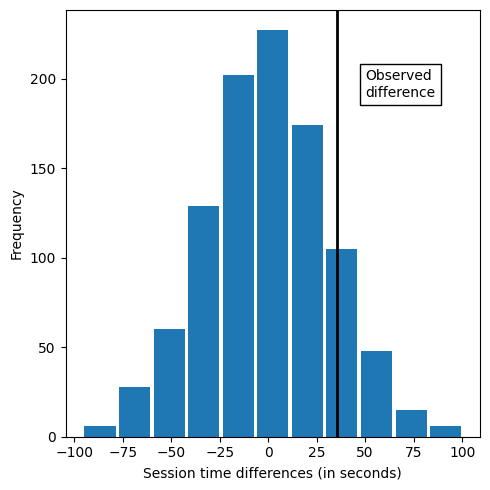

In [ ]:
random.seed(1) #랜덤시드 고정. 매 번 같은 히스토그램을 반환한다. 시드 안의 숫자를 바꾸면 결과가 달라진다.

perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)] #1000번 반복하여 리스트로 저장

# 히스토그램 그리기
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9) #rwidth : 막대들 사이의 간격

# 데이터로 계산한 값을 그래프에 표시
ax.axvline(x = mean_b - mean_a, color='black', lw=2)

ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
#p value
print('p value : ', np.mean(pd.Series(perm_diffs) > mean_b - mean_a))

p value :  0.121


#### p>0.05 이므로 두 페이지의 세션시간 차이는 통계적으로 유의하지 않다. 즉, A<B 라고 말할 수 없다.

## 2.  분할표에 대한 검정 - 카이제곱 검정

### 2-1. 팔짱 끼는 방식이 성별에 따라 차이가 있는지 알아보자.

**귀무가설 : 성별에 따른 차이가 없다. 즉 성별과 팔짱끼는 방식은 독립이다.**  

**대립가설 : 성별에 따라 차이가 있다. 즉 성별과 팔짱끼는 방식은 독립이 아니다.**

In [ ]:
# 데이터 생성
arms = pd.DataFrame(
    {'Women': [5,9],
     'Men' : [17,23]
    })
arms.index = ['left','right']
arms

,Women,Men
left,5,17
right,9,23


In [ ]:
# 카이제곱 검정 수행
# scipy.stats package의 chi2_contingency 함수를 이용한다.
chi2_stat = chi2_contingency(arms)
chi2_stat

Chi2ContingencyResult(statistic=0.016573660714285652, pvalue=0.8975643879419304, dof=1, expected_freq=array([[ 5.7037037, 16.2962963],
       [ 8.2962963, 23.7037037]]))

In [ ]:
print('p-value : ', chi2_stat.pvalue)

p-value :  0.8975643879419304


p=0.89로 귀무가설을 기각할 수 없으며, 따라서 성별에 따른 팔짱 끼는 방식에는 차이가 없다.

### 2-2. 로또 데이터를 이용한 적합도 검정


#### (1) 프랑스의 로또 데이터를 이용한 적합도 검정

**데이터의 카이제곱 검정통계량을 계산하자.**

In [ ]:
# 데이터 불러오기
fr_lotto = pd.read_excel(DATA+ '/fr_freq.xlsx')
fr_lotto

,number,frequency
0,1,368
1,2,357
2,3,385
3,4,362
4,5,397
...,...,...
85,86,358
86,87,315
87,88,389
88,89,348


In [ ]:
# 데이터를 통해 계산한 검정통계량
N=90 #전체 숫자
k=5 #뽑는 숫자
iter=6606 #반복횟수

# 기댓값 계산
Expected = iter*k/N #367

# 카이제곱 통계량 계산
sample_chi2 = sum((np.array(fr_lotto['frequency'])-Expected)**2)/Expected
sample_adj_chi2 = sample_chi2 * (N-1)/ (N-k)

print('데이터의 카이제곱 검정통계량 : ', sample_chi2)
print('데이터의 수정된 카이제곱 검정통계량 : ', sample_adj_chi2)

데이터의 카이제곱 검정통계량 :  95.74386920980926
데이터의 수정된 카이제곱 검정통계량 :  100.24946305497674


**이제, 모의실험을 통해 검정통계량의 분포를 만들어 보자.**

In [ ]:
# Step 1
# 1~90 중 비복원추출로 5개의 숫자를 뽑기

import random
def sample_numbers(iter):
    results=[] #empty list

    for _ in range(iter):
        sample=random.sample(range(1,N+1),k) #1~N 중 k개의 숫자를 임의로 뽑기
        results.append(sample) #뽑힌 5개의 값을 result list에 추가한다. 이 과정을 iter만큼 반복한다.

    return results

In [ ]:
# Step 2
# 위를 6606번 반복하자.

samples = sample_numbers(iter=6606)

for i in range(5):
    print(f"Sample {i+1}: {samples[i]}") #처음 5개만 print

Sample 1: [62, 80, 18, 10, 44]
Sample 2: [34, 24, 75, 36, 59]
Sample 3: [60, 40, 6, 27, 15]
Sample 4: [57, 82, 52, 12, 40]
Sample 5: [49, 30, 39, 75, 33]


In [ ]:
# Step 3
# 수정된 카이제곱 검정통계량을 계산하자.
# 복원추출이 아닌 비복원추출이므로, (검정통계량이 아닌) 수정된 검정통계량이 자유도가 N-1인 카이제곱분포를 따른다.

observed_freq = np.bincount(np.ravel(samples))[1:]
# sample을 넓게 펼친 후, 각 숫자가 몇 번씩 나오는지 count
# 0은 셀 필요가 없으므로, [1:]을 이용해 1 이후의 숫자에 대한 count만 observed_freq 로 저장한다.

observed_freq #1~90까지 숫자의 출현 빈도수

array([329, 387, 392, 356, 332, 375, 362, 393, 392, 383, 383, 362, 392,
       398, 383, 358, 346, 378, 384, 364, 352, 372, 363, 324, 362, 380,
       355, 385, 354, 395, 363, 388, 373, 365, 351, 381, 365, 335, 377,
       381, 367, 382, 341, 355, 347, 355, 329, 347, 349, 362, 367, 389,
       402, 356, 351, 401, 371, 367, 385, 369, 354, 364, 374, 353, 377,
       369, 388, 378, 387, 377, 359, 360, 365, 391, 343, 348, 348, 382,
       389, 378, 381, 342, 345, 400, 321, 325, 376, 369, 373, 352])

In [ ]:
chi2 = np.sum((observed_freq-Expected)**2 / Expected) #카이제곱 검정통계량
adj_chi2 = (N-1) * chi2 / (N-k) #수정 검정통계량

print('trial 1의 검정통계량 : ', chi2)
print('trial 1의 수정된 검정통계량 : ', adj_chi2)

# 수정된 검정통계량은 자유도가 N-1, 즉 89인 카이제곱분포를 따른다.
# k는 비복원추출되는 데이터의 개수로, 여기서는 k=5이다.

trial 1의 검정통계량 :  89.716621253406
trial 1의 수정된 검정통계량 :  93.93857990062511


In [ ]:
# Step 4
# 위 과정을 100번 반복하자.

def calculate_chi2_squared(iter, trial): #iter : 반복횟수 (6606), trial : step 1~3 전체의 반복 횟수 (100)
    chi2_values = []
    adj_chi2_values = []
    Expected = iter* k/N

    for _ in range(trial):

        #1. 샘플링
        samples = sample_numbers(iter) #6606번씩 샘플링

        #2. 카이제곱 검정통계량 계산
        observed_freq = np.bincount(np.ravel(samples))[1:]
        chi2 = np.sum((observed_freq - Expected)**2) / Expected

        #3. 수정된 카이제곱 검정 통계량 계산
        adj_chi2 = (N-1) * chi2 / (N-k)

        chi2_values.append(chi2)
        adj_chi2_values.append(adj_chi2)

    return chi2_values, adj_chi2_values

In [ ]:
# Step 5.
# 원래 데이터에서 계산한 검정통계량 sample_adj_chi2가
# 위의 100개 검정통계량과 비교해서 몇 번째로 큰지 세어보자.

##결과 출력
chi2_values, adj_chi2_values = calculate_chi2_squared(trial=100, iter=6606)

#모든 값 확인
#for i in range(num_iter):
    #print(f"Iteration {i+1}:")
    #print(f"  검정통계량 : {chi2_values[i]}")
    #print(f"  수정된 검정통계량 : {adj_chi2_values[i]}")
    #print()

np.sum(np.array(adj_chi2_values) > sample_adj_chi2)

16

In [ ]:
p_value = np.sum(np.array(adj_chi2_values) > sample_adj_chi2)/100
print('p value : ', p_value)

p value :  0.16


**p > 0.05이므로, 프랑스의 로또는 공정하다고 볼 수 있다.**

#### (2) 우리나라의 로또 데이터를 활용한 적합도 검정

- 우리나라 로또 : 45개의 번호 중 순서와 상관없이 당첨번호 6개를 맞추면 된다.

In [ ]:
kor_lotto = pd.read_excel(path+'/kor_freq.xlsx', usecols='B,C', header=1)
kor_lotto

,Number,Number of wins
0,1,154
1,2,142
2,3,151
3,4,148
4,5,140
5,6,146
6,7,151
7,8,141
8,9,116
9,10,148


In [ ]:
# 데이터를 통해 계산한 검정통계량
N=45 #전체 숫자
k=6 #뽑는 숫자
iter=1113 #반복횟수

# 기댓값 계산
Expected = iter*k/N #148.4

# 카이제곱 통계량 계산
sample_chi2 = sum((np.array(kor_lotto['Number of wins'])-Expected)**2)/Expected
sample_adj_chi2 = sample_chi2 * (N-1)/ (N-k)

print('데이터의 카이제곱 검정통계량 : ', sample_chi2)
print('데이터의 수정된 카이제곱 검정통계량 : ', sample_adj_chi2)

데이터의 카이제곱 검정통계량 :  29.66846361185984
데이터의 수정된 카이제곱 검정통계량 :  33.472112792867506


**이제, 모의실험을 통해 로또가 공정한지 알아보자.**

In [ ]:
# 위에서 정의한 함수들을 이용하자.

N=45 #전체 숫자의 갯수
k=5 #비복원추출로 뽑는 숫자의 갯수
iter=1113 #반복횟수
trial=100 #전체 반복 횟수

chi2_values, adj_chi2_values = calculate_chi2_squared(iter=iter, trial=trial)
p_value = np.sum(np.array(adj_chi2_values) > sample_adj_chi2)/100
print('p value : ', p_value)

p value :  0.89


**p value > 0.05 이므로, 우리나라의 로또도 공정함을 알 수 있다.**
* 우리나라 로또가 더 공정하다 (?)
* 로또가 공정하다는 귀무가설에 대한 p-value는 우리나라가 프랑스보다 더 크다.

**수정된 카이제곱통계량은 자유도가 N-1인 카이제곱분포를 따른다. 이를 시각화하여 나타내보자.**

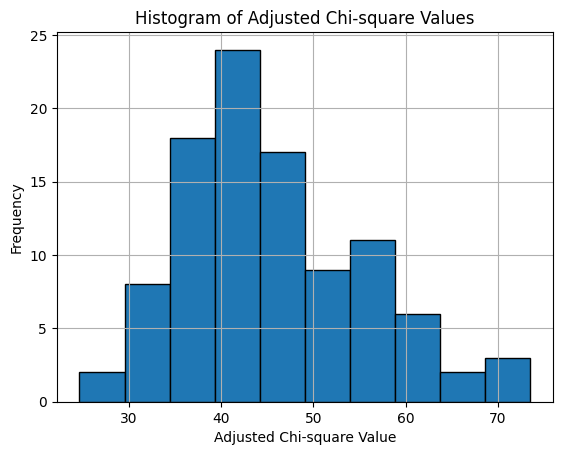

In [ ]:
# 그래프를 그려보자.

random.seed(42)
chi2_values, adj_chi2_values = calculate_chi2_squared(iter=iter, trial=trial)

import matplotlib.pyplot as plt

plt.hist(adj_chi2_values, bins=10, edgecolor='black')

plt.xlabel('Adjusted Chi-square Value')
plt.ylabel('Frequency')
plt.title('Histogram of Adjusted Chi-square Values')
plt.grid(True)

plt.show()

**위 수정된 검정통계량은 자유도가 n-1인 카이제곱분포를 따른다.  
카이제곱분포를 위 히스토그램 위에 그려보자.**

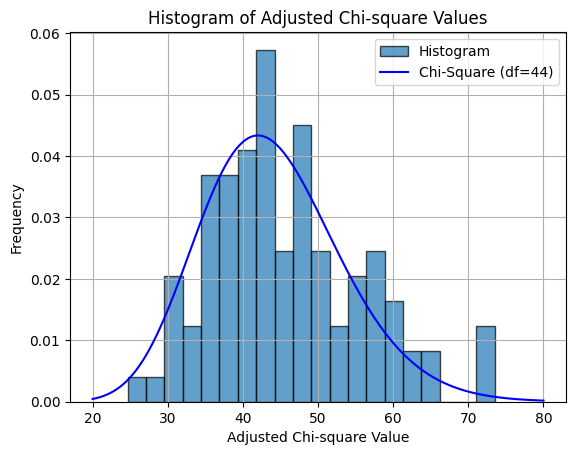

In [ ]:
from scipy.stats import chi2

# 자유도 설정
df = N-1 #N=45

# X축 범위 설정
x = np.linspace(20,80,1000) #20~80까지 1000개 값 추출

# 카이제곱 확률밀도함수 계산
y = chi2.pdf(x,df) # 위 x에 해당되는 카이제곱 확률밀도함수 값 계산

# 히스토그램 그리기
plt.hist(adj_chi2_values, bins=20, edgecolor='black',
         density=True, alpha=0.7, label='Histogram')

# 확률밀도함수 그래프 그리기
plt.plot(x,y,label=f"Chi-Square (df={df})", color='blue')

plt.xlabel('Adjusted Chi-square Value')
plt.ylabel('Frequency')
plt.title('Histogram of Adjusted Chi-square Values')
plt.grid(True)
plt.legend()

plt.show()

**데이터를 통해 계산한 검정통계량 값을 위 그래프에 표시해보자.**

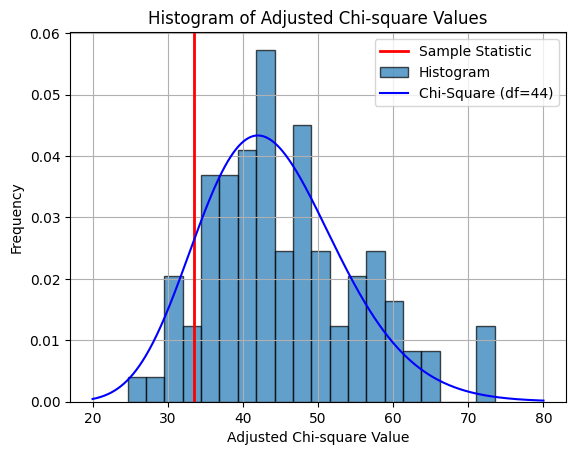

In [ ]:
fig, ax = plt.subplots()

# 데이터의 검정통계량 표시
ax.axvline(sample_adj_chi2, color='red', lw=2, label='Sample Statistic')

# 히스토그램 그리기
plt.hist(adj_chi2_values, bins=20, edgecolor='black',
         density=True, alpha=0.7, label='Histogram')

# 확률밀도함수 그래프 그리기
plt.plot(x,y,label=f"Chi-Square (df={df})", color='blue')

plt.xlabel('Adjusted Chi-square Value')
plt.ylabel('Frequency')
plt.title('Histogram of Adjusted Chi-square Values')
plt.grid(True)
plt.legend()

plt.show()

- 빨간색으로 표시한 값은 데이터의 위치를 나타낸다.
- 빨간색 선보다 더 오른쪽에 있는 값들이 많다.
- 이는 데이터가 그다지 극단적인 값이 아님을 의미한다.
- 즉, '로또가 공정하다' 는 귀무가설 하에서 충분히 나올 수 있는 값이다.

# Lecture 8. 분산분석과 검정력

## 1. 검정력의 계산

- 수업시간에 다룬 예제를 살펴보자.
- 표본 A : 평균 20, 분산 2인 정규분포에서 30개의 데이터 생성
- 표본 B : 평균 25, 분산 2인 정규분포에서 30개의 데이터 생성

In [ ]:
np.random.seed(1)

#샘플 데이터 생성
sample_A = np.random.normal(20, np.sqrt(2), 30)
sample_B = np.random.normal(25, np.sqrt(2), 30)

# t검정 수행
# 귀무가설 : A의 평균 = B의 평균
# 대립가설 : A의 평균 != B의 평균
t_statistic, p_value = stats.ttest_ind(sample_A,sample_B)
print(p_value) #e-22 = 10^(-22)

8.411685419473787e-22


p value가 매우 작으므로, 귀무가설을 기각한다.

**샘플 사이즈를 30개에서 10개로 바꾼 후, 위 과정을 100번 반복하자.**

In [ ]:
# 모수 지정
mean_A, mean_B = 20, 22 # 각각의 평균
variance = 2 # 분산은 동일
sample_size = 10 # 한 번에 뽑을 샘플 사이즈를 지정
num_simulations = 100 # 전체 반복 횟수 지정
alpha = 0.05  # 유의수준 지정

# A, B 각각의 정규분포에서 랜덤하게 숫자를 뽑아 이에 대한 ttest를 수행하는 함수
def perform_ttest(sample_size, mean_A, mean_B, variance, alpha):

    # 샘플 데이터 생성
    sample_A = np.random.normal(mean_A, np.sqrt(variance), sample_size)
    sample_B = np.random.normal(mean_B, np.sqrt(variance), sample_size)

    # t test 수행
    t_statistic, p_value = stats.ttest_ind(sample_A, sample_B)

    # p value 가 유의수준보다 작으면 기각한다.
    reject_null = p_value < alpha

    return reject_null

# 시뮬레이션
reject_counts = 0
for _ in range(num_simulations):
    reject_null = perform_ttest(sample_size, mean_A, mean_B, variance, alpha)
    if reject_null:
        reject_counts += 1

# 검정력 계산
power = reject_counts / num_simulations

print(f"size=10인 샘플을 이용한 검정력 : {power}")


size=10인 샘플을 이용한 검정력 : 0.84


In [ ]:
# 표본 크기가 작아진다면?
sample_size=5

# 시뮬레이션
reject_counts = 0
for _ in range(num_simulations):
    reject_null = perform_ttest(sample_size, mean_A, mean_B, variance, alpha)
    if reject_null:
        reject_counts += 1

# 검정력 계산
power = reject_counts / num_simulations

print(f"size=5인 샘플을 이용한 검정력 : {power}")


size=5인 샘플을 이용한 검정력 : 0.49


표본 크기가 작아지면, 검정력도 작아진다.

## 2. 분산분석 - 여러 그룹 간의 비교 (Multiple group comparision)

- 4개의 페이지 각각에서 사람들이 머무는 시간을 나타내는 데이터이다.
- 페이지별로 머무는 시간이 다를까?

In [ ]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

four_sessions.groupby('Page').mean() #페이지 별 평균 계산

,Time
Page,
Page 1,172.8
Page 2,182.6
Page 3,175.6
Page 4,164.6


In [ ]:
#이에 대한 분산 계산
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Variance:', observed_variance)

Variance: 55.426666666666655


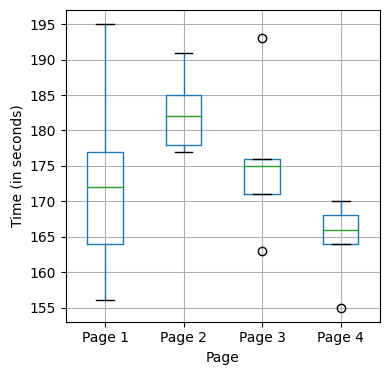

In [ ]:
# 상자그림을 통해 평균이 다른지 확인해보자.

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

그림을 보면 평균 간 차이가 꽤 많이 나 보인다.
ANOVA를 이용해 확인해보자.

#### ANOVA (F-test)
**귀무가설 : 페이지 별 세션시간의 평균이 모두 같다.**  

**대립가설 : 페이지 별 세션시간의 평균이 모두 같지는 않다.**

**alpha = 0.1로 두자.**

- scipy 내의 stats.f_oneway를 이용한다.
- f_oneway는 2개 이상의 그룹이 같은 평균을 갖는지를 검정하기 위한 함수이다.
- 각 샘플의 크기가 달라도 사용할 수 있다.

In [ ]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time,
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)

print(f'F-Statistic: {res.statistic :.4f}')
print(f'p-value: {res.pvalue :.4f}')

F-Statistic: 2.7398
p-value: 0.0776


**p_value = 0.07이다. 따라서 유의수준 0.1 하에서 그룹 간 차이가 있다는 결론을 내릴 수 있다.**  

**그러나 어떤 그룹의 평균이 다른지는 ANOVA를 통해서는 알 수 없다. 사후분석이 추가적으로 필요하다.**


#### 순열검정
- 3000번 반복해서 그 결과를 히스토그램으로 표시해보자.

In [ ]:
# numpy의 random.permutation 함수를 이용하자.

# 페이지 별 세션 시간을 랜덤하게 섞고, 평균을 낸 후 분산을 계산하는 함수
def perm_test(df):
    df = df.copy() #df 파일을 그대로 복사
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

p-value :  0.08266666666666667


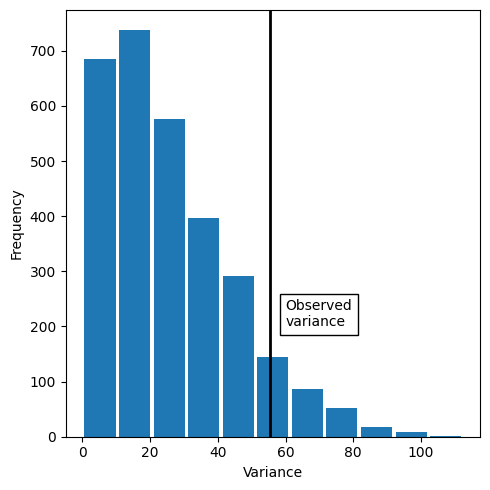

In [ ]:
# 3000번 반복의 결과를 히스토그램으로 표현해보자.

random.seed(1)

perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('p-value : ', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

- p=0.08이다.
- 0.1보다는 작다. 따라서 유의수준 0.1 하에서는 페이지 간 세션 시간에 유의한 차이가 난다고 말할 수 있다.
- 그러나 0.05보다는 크다. 따라서 유의수준 0.05 하에서는 페이지 간 세션 시간에 유의한 차이가 난다고 말할 수 없다.
- 앞서 데이터만 가지고 ANOVA를 했을 때와는 다른 결론을 얻을 수 있다.